# 📊 IPO HeatScore 기반 비수기 정의 및 DAU 비교 분석

IPO 일정 데이터를 날짜 기준 이벤트 밀도로 변환하여 시장 활성도를 HeatScore로 정량화하고,
앱 일일접속자(DAU)와 비교하여 서비스 비수기 구조를 정의한다.

# 0️⃣ 라이브러리 로드 및 환경 설정

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 🔧 경고 메시지 제거 (포트폴리오 시각화용)
warnings.filterwarnings("ignore")

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1️⃣ IPO 일정 데이터 로드 및 전처리

In [2]:
df = pd.read_excel("./data/IPO정리.xlsx")

In [4]:
#날짜형 데이터 변환
date_cols = [
    "수요예측 시작일","수요예측 종료일",
    "청약 시작일","청약 종료일",
    "상장예정일"
]

for c in date_cols:
    df[c] = (
        df[c]
        .astype(str)                      # 문자열 강제 변환
        .str.replace("\xa0", "", regex=False)   # 🔥 NBSP 제거
        .str.strip()                      # 앞뒤 공백 제거
    )
    df[c] = pd.to_datetime(df[c], errors="coerce")

# 2️⃣ 날짜별 IPO 이벤트 밀도 계산

In [5]:
#전체 날짜 범위 생성
date_range = pd.date_range(
df["수요예측 시작일"].min(),
df["상장예정일"].max()
)

heat = pd.DataFrame({"날짜": date_range})

#날짜 포함 여부 계산
heat["수요예측개수"] = heat["날짜"].apply(
    lambda d: ((df["수요예측 시작일"] <= d) &
               (df["수요예측 종료일"] >= d)).sum()
)

heat["청약개수"] = heat["날짜"].apply(
    lambda d: ((df["청약 시작일"] <= d) &
               (df["청약 종료일"] >= d)).sum()
)

heat["상장개수"] = heat["날짜"].apply(
    lambda d: (df["상장예정일"] == d).sum()
)

# 3️⃣ HeatScore 지표 생성 및 비수기 정의

In [6]:
#HeatScore & 비수기 만들기
heat["HeatScore"] = (
    heat["수요예측개수"]*1 +
    heat["청약개수"]*3 +
    heat["상장개수"]*3
)

heat["시즌구분"] = heat["HeatScore"].apply(
    lambda x: "비수기" if x <= 1 else "성수기"
)

In [7]:
df = pd.DataFrame(heat)

In [8]:
df

,날짜,수요예측개수,청약개수,상장개수,HeatScore,시즌구분
0,2023-02-21,1,0,0,1,비수기
1,2023-02-22,1,0,0,1,비수기
2,2023-02-23,1,0,0,1,비수기
3,2023-02-24,1,0,0,1,비수기
4,2023-02-25,0,0,0,0,비수기
...,...,...,...,...,...,...
1102,2026-02-27,0,0,0,0,비수기
1103,2026-02-28,0,0,0,0,비수기
1104,2026-03-01,0,0,0,0,비수기
1105,2026-03-02,0,0,0,0,비수기


In [9]:
df.to_excel("HeatScore결과.xlsx", index=False)

# 4️⃣ DAU 데이터 결합

In [10]:
h_df = pd.read_excel("./data/HeatScore결과.xlsx")
v_df = pd.read_excel("./data/일일접속자.xlsx")

In [11]:
merged = pd.merge(
    h_df,
    v_df,
    on="날짜",
    how="left"
)

In [12]:
merged

,날짜,수요예측개수,청약개수,상장개수,HeatScore,시즌구분,일접속률,접속자현황
0,2023-02-21,1,0,0,1,비수기,0.226675,28.105590
1,2023-02-22,1,0,0,1,비수기,0.200185,25.194099
2,2023-02-23,1,0,0,1,비수기,0.189528,24.029503
3,2023-02-24,1,0,0,1,비수기,0.138821,17.740683
4,2023-02-25,0,0,0,0,비수기,0.151762,19.565217
...,...,...,...,...,...,...,...,...
1040,2025-12-27,0,0,0,0,비수기,0.025107,73.291925
1041,2025-12-28,0,0,0,0,비수기,0.050251,146.816770
1042,2025-12-29,0,0,1,3,성수기,0.104225,304.930124
1043,2025-12-30,0,0,0,0,비수기,0.055053,161.257764


In [13]:
merged.to_excel("HeatScore_일일접속_통합.xlsx", index=False)

# 5️⃣ HeatScore vs DAU 시계열 시각화 (비수기 음영 포함)

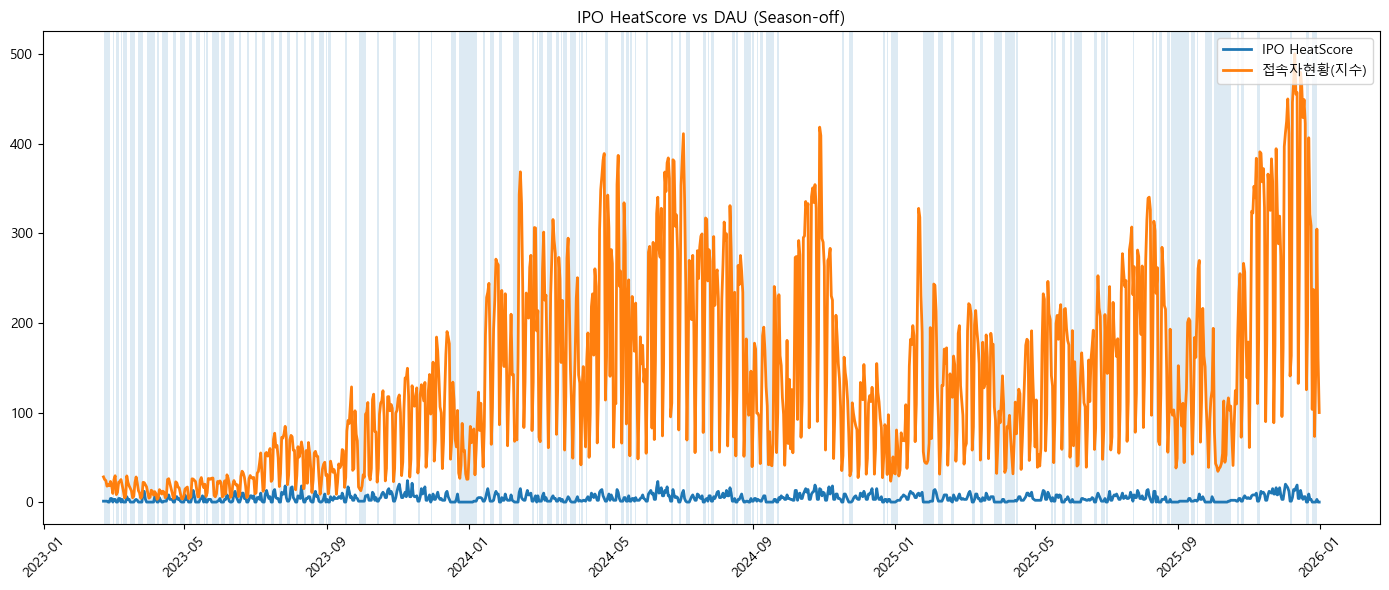

In [14]:
plt.figure(figsize=(14,6))

plt.plot(merged["날짜"], merged["HeatScore"], label="IPO HeatScore", linewidth=2)
plt.plot(merged["날짜"], merged["접속자현황"], label="접속자현황(지수)", linewidth=2)

# 🔥 연속된 비수기 구간 음영 처리
is_off = merged["시즌구분"]=="비수기"
start = None

for i in range(len(merged)):
    if is_off.iloc[i] and start is None:
        start = merged["날짜"].iloc[i]
    elif not is_off.iloc[i] and start is not None:
        plt.axvspan(start, merged["날짜"].iloc[i], alpha=0.15)
        start = None

plt.legend()
plt.title("IPO HeatScore vs DAU (Season-off)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
merged.groupby("시즌구분")["접속자현황"].describe()

,count,mean,std,min,25%,50%,75%,max
시즌구분,,,,,,,,
비수기,353.0,71.988106,57.789858,3.066770,25.271739,58.035714,106.754658,269.992236
성수기,692.0,164.869583,110.723317,8.734472,68.866460,142.255435,243.779115,500.776398


# 6️⃣ 시즌별 방문자 분포 비교 (Boxplot)

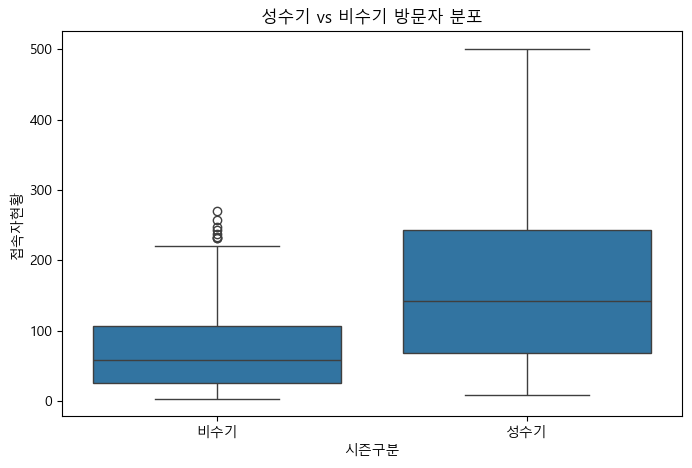

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


plt.figure(figsize=(8,5))

sns.boxplot(
    data=merged,
    x="시즌구분",
    y="접속자현황"
)

plt.title("성수기 vs 비수기 방문자 분포")
plt.show()

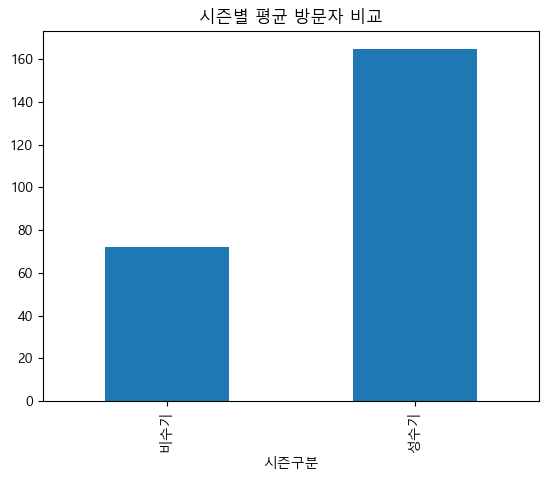

In [17]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

merged.groupby("시즌구분")["접속자현황"].mean().plot(
    kind="bar",
    title="시즌별 평균 방문자 비교"
)
plt.show()

# 📌핵심 인사이트

1. IPO 일정 데이터를 날짜 단위 이벤트 밀도로 재구성하여
   HeatScore라는 시장 활성도 지표를 정의하였다.

2. HeatScore가 낮은 비수기 구간에서 DAU는
   낮고 안정적인 패턴을 보이며,
   이는 사용자 이탈보다는 IPO 이벤트 공백과
   같은 외부 요인의 영향을 시사한다.

3. 성수기는 이벤트 기반 유입으로 변동성이 크고,
   비수기는 코어 사용자 중심 유지 구조로 해석 가능하다.

👉 따라서 비수기 전략은 신규 이벤트 의존이 아닌
   리텐션 및 참여형 콘텐츠 중심으로 설계할 필요가 있다.